In [300]:
import torch
import torch.nn.functional as F
from torch import Tensor
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [301]:
def readFileSplitByLine(name: str) -> list[str]:
    words = open(name, 'r').read().splitlines()
    return words


def sToI(chars: list[str]) -> dict[str, int]:
   stoi = { '.' : 0 }
   for i, ch in enumerate(chars):
       stoi[ch] = i + 1
   return stoi


def iToS(stoi: dict[str, int]) -> dict[int, str]:
    return {i:s for s,i in stoi.items()}


def buildDataSet(words: list[str], 
                 contextSize: int, 
                 stoi: dict[str, int], 
                 itos: dict[int, str]) -> tuple[Tensor, Tensor]:
    X: list[list[int]] = []
    Y: list[int] = []
    for w in words:
        context = [0] * contextSize
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)


class NetParameters:
    C: Tensor
    W1: Tensor
    b1: Tensor
    W2: Tensor
    b2: Tensor
    all: list[Tensor]


def makeNetwork(g: torch.Generator, 
                vocabularySize: int, 
                embeddingSize: int, 
                contextSize: int, 
                hiddenLayerSize: int) -> NetParameters:
    np = NetParameters()
    np.C = torch.randn((vocabularySize, embeddingSize), generator = g)
    np.W1 = torch.randn((embeddingSize * contextSize, hiddenLayerSize), generator = g)
    np.b1 = torch.randn(hiddenLayerSize, generator = g)
    np.W2 = torch.randn((hiddenLayerSize, vocabularySize), generator = g)
    np.b2 = torch.randn(vocabularySize, generator = g) 
    np.all = [np.C, np.W1, np.b1, np.W2, np.b2]
    for p in np.all:
        p.requires_grad = True
    return np


class ForwardPassResult:
    emb: Tensor
    h: Tensor
    logits: Tensor
    loss: Tensor


def forwardPass(np: NetParameters,
                trX: Tensor,
                ix: Tensor,
                embeddingSize: int,
                contextSize: int,
                trY: Tensor) -> ForwardPassResult:
    r = ForwardPassResult()
    r.emb = np.C[trX[ix]]
    r.h = torch.tanh(r.emb.view(-1, embeddingSize * contextSize) @ np.W1 + np.b1)
    r.logits = r.h @ np.W2 + np.b2
    r.loss = F.cross_entropy(r.logits, trY[ix])
    return r


def backwardPass(parameters: list[Tensor],
                 loss: Tensor) -> None:
  for p in parameters:
    p.grad = None
  loss.backward()


def updateNet(parameters: list[Tensor],
              iteration: int):
    #learningRate = lrs[iteration]
    learningRate = 0.1 if iteration < 50_000 else 0.01
    for p in parameters:
       p.data += -learningRate * p.grad # type: ignore


def sample(np: NetParameters,
        g: torch.Generator,
        contextSize: int,
        itos: dict[int, str],
        countSamples: int):
    for _ in range(countSamples):
        out = []
        context = [0] * contextSize
        while True:
            emb = np.C[torch.tensor([context])] # (1,block_size,d)
            h = torch.tanh(emb.view(1, -1) @ np.W1 + np.b1)
            logits = h @ np.W2 + np.b2
            #counts = logits.exp() # counts, equivalent to next character
            #probs = counts / counts.sum(1, keepdim=True) # probabilities for next character
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        print(''.join(itos[i] for i in out))


In [302]:
rndSeed = 42
contextSize = 3
trRatio = 0.8
devRatio = 0.9
embeddingSize = 10 # the dimensionality of the character embedding vectors
hiddenLayerSize = 200 # the number of neurons in the hidden layer of the MLP
maxTrainingSteps = 20_000
trainingBatchSize = 32
rndSeed2 = 2147483647
g = torch.Generator().manual_seed(rndSeed2)
gSampling = torch.Generator().manual_seed(rndSeed2 + 10)


words = readFileSplitByLine('names.txt')[:100000]
random.seed(rndSeed)
random.shuffle(words)
print('first few words:\n', words[:5])

lenWords = len(words);
print('lenWords:\n', lenWords)

allPossibleChars = sorted(list(set(''.join(words))))
print('allPossibleChars:\n', allPossibleChars)

stoi = sToI(allPossibleChars)
print('stoi:\n', stoi)

itos = iToS(stoi)
print('itos:\n', itos)

vocabularySize = len(itos)
print('vocabularySize:\n', vocabularySize)

lenTrain = int(trRatio * lenWords)
trWords = words[:lenTrain]
trX, trY = buildDataSet(trWords, contextSize, stoi, itos)

lenDev = int(devRatio * lenWords)
devWords = words[lenTrain:lenDev];
devX, devY = buildDataSet(devWords, contextSize, stoi, itos)

lenTest = lenDev - lenTrain
tstWords = words[lenDev:]
tstX, tstY = buildDataSet(tstWords, contextSize, stoi, itos)

print('lenTrain, lenDev, lenTest:\n', lenTrain, lenDev, lenTest)

np = makeNetwork(g, vocabularySize, embeddingSize, contextSize, hiddenLayerSize)
print('parametersCount:\n', sum(p.nelement() for p in np.all))

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []
fr: ForwardPassResult = ForwardPassResult()

for i in range(maxTrainingSteps):    

  # mini-batch construct
  ix = torch.randint(0, trX.shape[0], (trainingBatchSize,), generator=g)

  fr = forwardPass(np, trX, ix, embeddingSize, contextSize, trY)  

  if (i == 0):
    print('intial loss:\n', fr.loss.item());

  #if i % 1_000 == 0:
  #    print(fr.loss.item())
      
  backwardPass(np.all, fr.loss)
  
  # update
  updateNet(np.all, i)

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(fr.loss.item())

print('emb.shape:\n', fr.emb.shape)
print('h.shape:\n', fr.h.shape)
print('logits.shape:\n', fr.logits.shape);
print('loss:\n', fr.loss.item());

first few words:
 ['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']
lenWords:
 32033
allPossibleChars:
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:
 {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos:
 {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
vocabularySize:
 27
lenTrain, lenDev, lenTest:
 25626 28829 3203
parametersCount:
 11897
intial loss:
 27.88172721862793
emb.shape:
 torch.Size([32, 3, 10])
h.shape:
 torch.Size([32, 200])
logits.shape:
 torch.Size([32, 27])
loss:
 1.9759081602096558


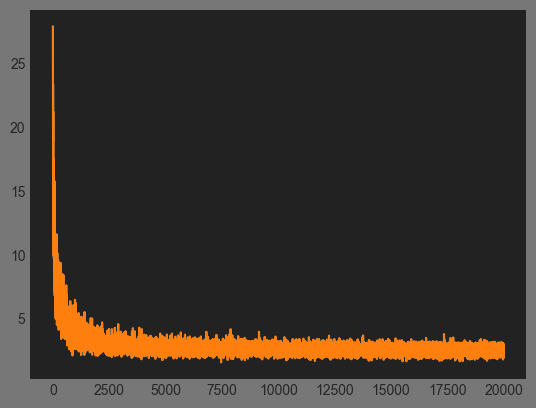

In [303]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
ax.plot(stepi, lossi)
ax.plot(stepi, lossi)
plt.show()

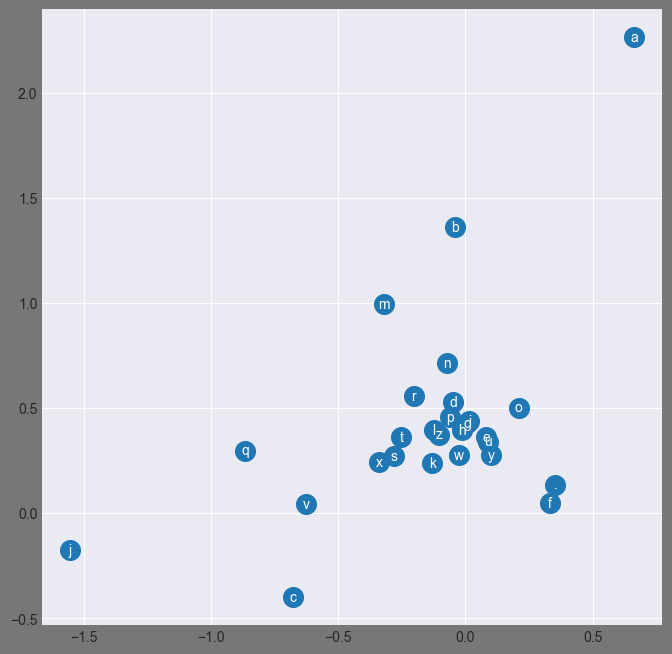

In [334]:
dim = 4
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('#777777')
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [311]:
sample(np, gSampling, contextSize, itos, 20)

ran.
ankaileigh.
pay.
dandanrescea.
jacarra.
ann.
ahoah.
mara.
brey.
ani.
jaemba.
azon.
kaylenah.
margeldanvee.
haythera.
jatcuon.
larde.
ysrichan.
kalmera.
aranven.
